In [1]:
from pathlib import Path
from copy import deepcopy

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from shapely import union
from shapely.geometry import box, Point
from pyproj import CRS

import ocsmesh

Path for raster files to be used (last in list has higher priority)

In [2]:
rasters_path = [
    '/home/smani/workarea/test/win/DEM/GEBCO/gebco_2020_n0.0_s-90.0_w-90.0_e0.0.tif',
]

Define domain extents

In [3]:
domain_crs = CRS.from_user_input('epsg:4326')
domain_bbox = box(-65.5, -42.5, -63.5, -40.5)
domain = union(domain_bbox, Point(-63.5, -41.5).buffer(1))

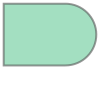

In [4]:
domain

For clipping input raster buffer the original domain to avoid issues at the edges of the clipping region (buffer by 1 percent length scale)

In [5]:
base_shape = domain.buffer(0.01 * domain.area / domain.length)
rasters = [ocsmesh.Raster(p) for p in rasters_path]

In [6]:
geom = ocsmesh.Geom(
    deepcopy(rasters),
    zmin=None,
    zmax=10,
    base_shape=base_shape,
    base_shape_crs=domain_crs,
)
domain_poly = geom.get_multipolygon()

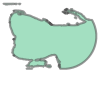

In [7]:
domain_poly

In [8]:
hfun = ocsmesh.Hfun(
    deepcopy(rasters),
    hmin=100,
    hmax=10000,
    base_shape=base_shape,
    base_shape_crs=domain_crs
)
hfun.add_contour(
    level=0,
    target_size=100,
    expansion_rate=0.1,
)
hfun.add_constant_value(
    value=100,
    lower_bound=0,
)
hfun_msht = hfun.msh_t()

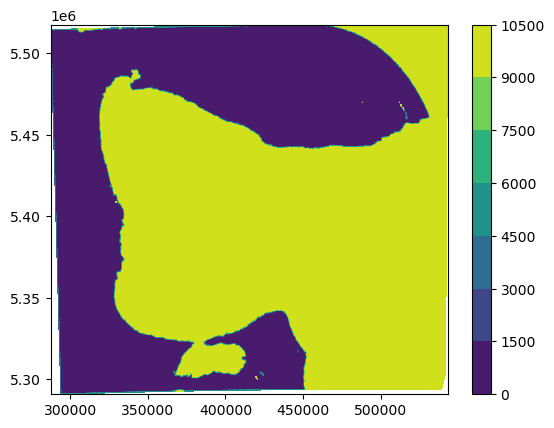

In [9]:
plt.tricontourf(
    Triangulation(
        hfun_msht.vert2['coord'][:, 0],
        hfun_msht.vert2['coord'][:, 1],
        triangles=hfun_msht.tria3['index']
    ),
    hfun_msht.value.flatten(),
)
plt.colorbar()

In [10]:
# Initializing mesh with hfun causes weird boundaries
driver = ocsmesh.JigsawDriver(geom, hfun, initial_mesh=False)
mesh = driver.run()

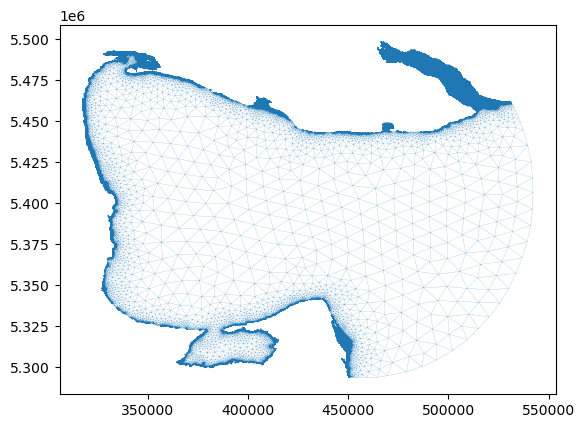

In [11]:
plt.triplot(
    mesh.msh_t.vert2['coord'][:, 0],
    mesh.msh_t.vert2['coord'][:, 1],
    triangles=mesh.msh_t.tria3['index'],
    lw=0.1
)

In [12]:
mesh.interpolate(rasters, method='linear')

mesh.write('./mesh.2dm', format='2dm', overwrite=True)

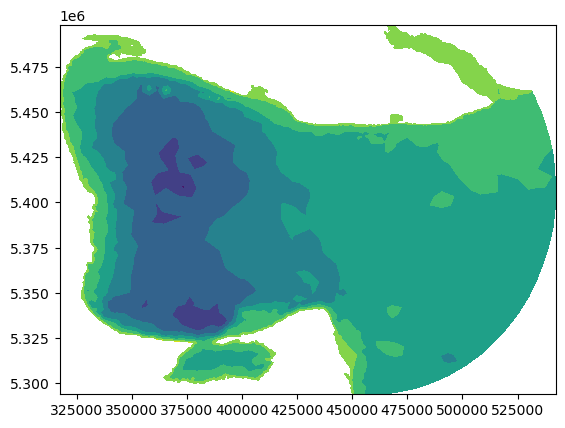

In [13]:
plt.tricontourf(
    Triangulation(
        mesh.msh_t.vert2['coord'][:, 0],
        mesh.msh_t.vert2['coord'][:, 1],
        triangles=mesh.msh_t.tria3['index']
    ),
    mesh.msh_t.value.flatten(),
)